In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import platform
import re

file_path = "/Users/a/Desktop/cursor/DataAnalysis/유저동향_요약결과_SQLite.xlsx"

period_df = pd.read_excel(file_path, sheet_name="1_기간별_게시글수")
region_df = pd.read_excel(file_path, sheet_name="2_지역별_비율")
neg_df = pd.read_excel(file_path, sheet_name="3_부정긍정비율")
source_df = pd.read_excel(file_path, sheet_name="4_출처비율")

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
def extract_start_month(text):
    match = re.match(r"(\d+)월", str(text))
    return int(match.group(1)) if match else 0

for df in [period_df, region_df, neg_df, source_df]:
    df["month_order"] = df["동향 확인 기간"].apply(extract_start_month)
    df.sort_values(by="month_order", inplace=True)
    df.drop(columns=["month_order"], inplace=True)

## 기간별 게시글 수 추이

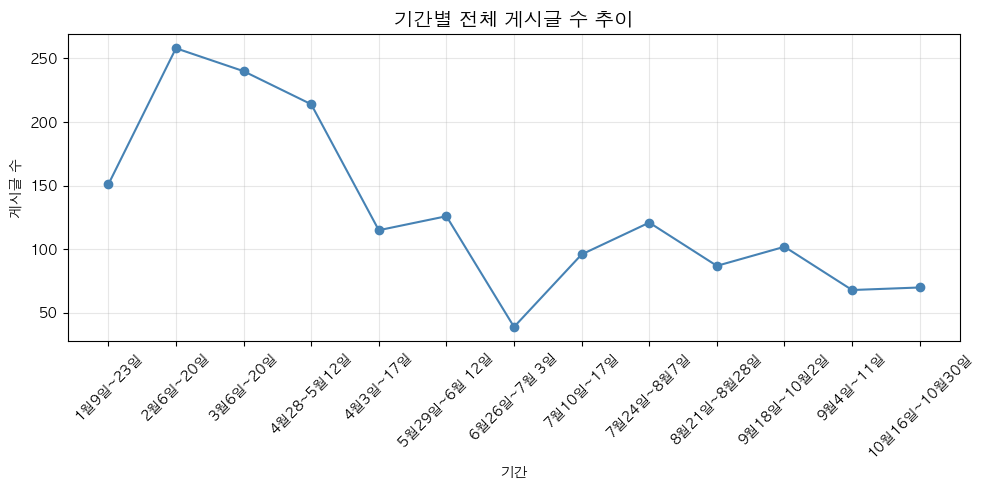

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(period_df["동향 확인 기간"], period_df["게시글 수"], marker="o", color="steelblue")
plt.title("기간별 전체 게시글 수 추이", fontsize=14, weight="bold")
plt.xlabel("기간")
plt.ylabel("게시글 수")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 지역별 비율

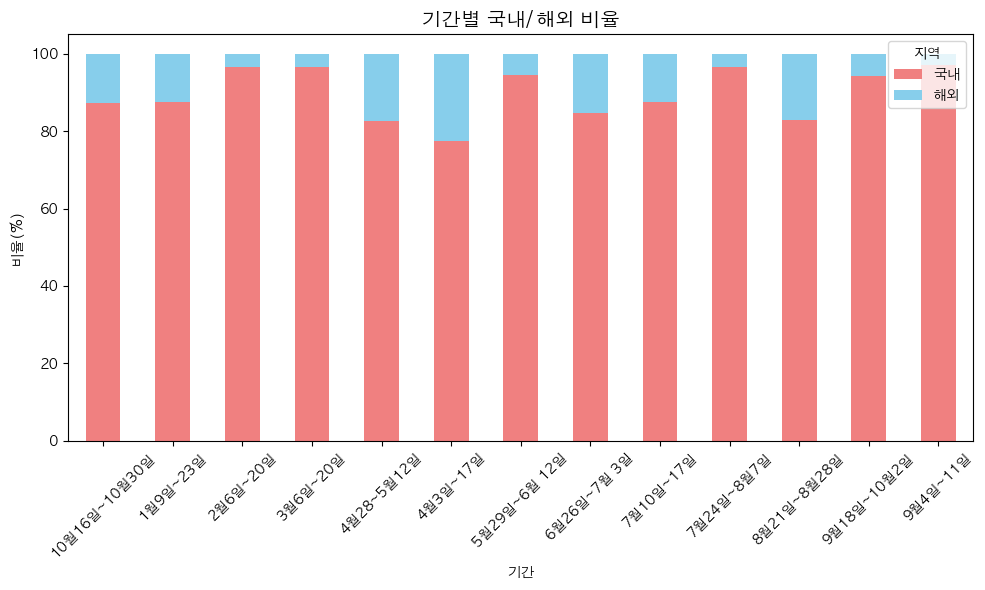

In [17]:
pivot_region = region_df.pivot(index="동향 확인 기간", columns="지역", values="비율(%)").fillna(0)
pivot_region.plot(kind="bar", stacked=True, figsize=(10, 6), color=["lightcoral", "skyblue"])
plt.title("기간별 국내/해외 비율", fontsize=14, weight="bold")
plt.xlabel("기간")
plt.ylabel("비율(%)")
plt.xticks(rotation=45)
plt.legend(title="지역", loc="upper right")
plt.tight_layout()
plt.show()

## 부정/긍정 비율

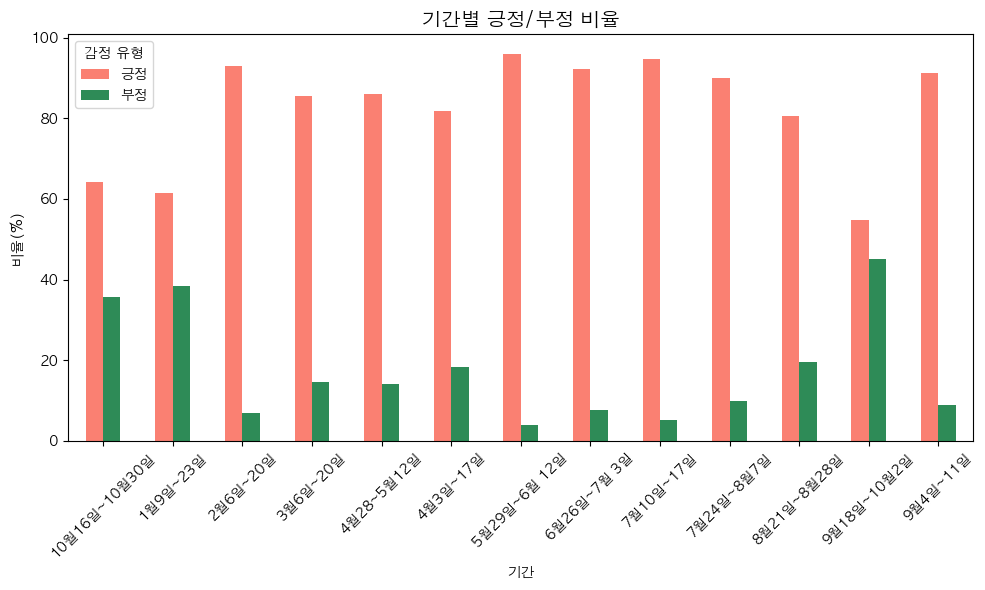

In [18]:
pivot_neg = neg_df.pivot(index="동향 확인 기간", columns="부정여부", values="비율(%)").fillna(0)
pivot_neg.plot(kind="bar", figsize=(10, 6), color=["salmon", "seagreen"])
plt.title("기간별 긍정/부정 비율", fontsize=14, weight="bold")
plt.xlabel("기간")
plt.ylabel("비율(%)")
plt.xticks(rotation=45)
plt.legend(title="감정 유형")
plt.tight_layout()
plt.show()

## 출처별 게시글 비율

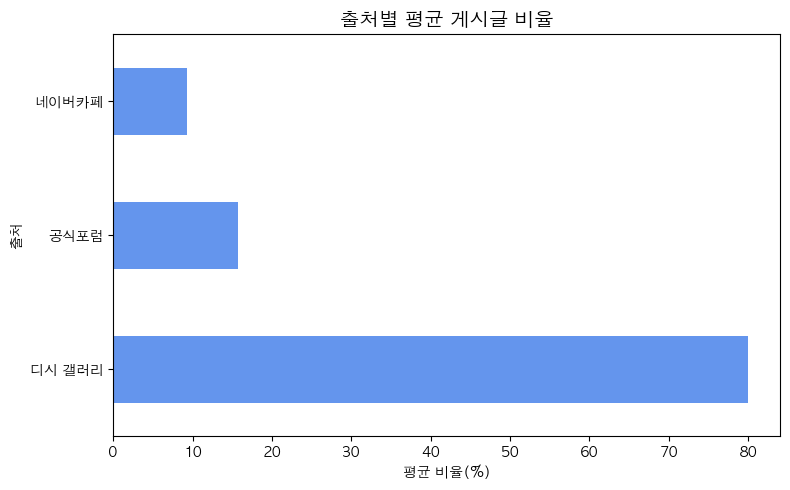

In [19]:
avg_source = source_df.groupby("출처")["비율(%)"].mean().sort_values(ascending=False)
avg_source.plot(kind="barh", figsize=(8, 5), color="cornflowerblue")
plt.title("출처별 평균 게시글 비율", fontsize=14, weight="bold")
plt.xlabel("평균 비율(%)")
plt.ylabel("출처")
plt.tight_layout()
plt.show()

## 기간별 부정률 변화 추이

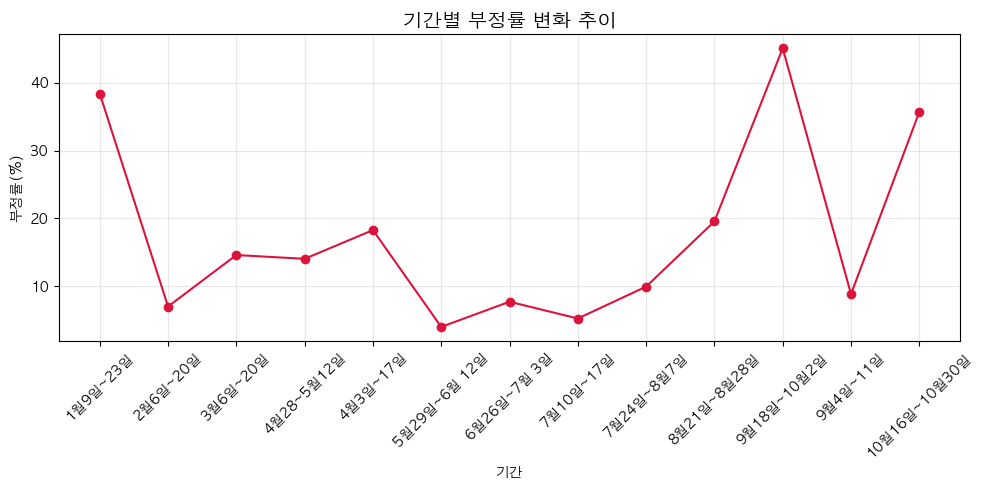

In [20]:
neg_trend = neg_df[neg_df["부정여부"] == "부정"]
plt.figure(figsize=(10, 5))
plt.plot(neg_trend["동향 확인 기간"], neg_trend["비율(%)"], marker="o", color="crimson")
plt.title("기간별 부정률 변화 추이", fontsize=14, weight="bold")
plt.xlabel("기간")
plt.ylabel("부정률(%)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
